# RANS Airfoil Flows with Bayesian Neural Nets

## Overview

We are now considering the same setup as in the notebook {doc}`supervised-airfoils`: A turbulent airflow around wing profiles, for which we'd like to know the average motion
and pressure distribution around this airfoil for different Reynolds numbers and angles of attack. In the earlier notebook, we tackled this by completely bypassing any physical solver and instead training a neural network that learns the quantities of interest. Now, we will use Evidential Learning \cite{Evidentialsensoy, Evidential},  differentiates itself by replacing a classical NN's softmax layer with an evidence vector, predicting the Dirichlet distribution parameters. For a given sample $x_i$ for a K-class classification problem, the cross entropy loss to be minimized for learning evidence $e_i$ is ${L}(i_i,e_i,\theta)=\sum_{k=1}^K y_i^k(log S_i-log(e_i^k+1))$ ; where $y_i$ is the one-hot k-dimmensional label, $S$ is the total strength of the Dirichlet function $DIR(p\mid\alpha)$ which is parametrized by $\alpha\in{R}$ and $S=\sum_{k=1}^k \alpha_k$, $e_i=g(f(x_i;\theta))$ with $f$ as the output of the NN parametrized by $\theta$ and g as the evidence function to keep $e_k$ non-negative. Based on \cite{Evidentialsensoy} $\alpha_k=e_k+1$. For the inference step, the probabilities for each class $k$ are then given by ${p_k}=\frac{\alpha_k}{S}$. The uncertainty for each sample is $u=\frac{K}{S}$. For more information \cite{Evidentialsensoy, Evidential} and the code provided in Appendix A.

Article={Evidential Deep Learning to Quantify Classification Uncertainty},
      author={Murat Sensoy and Lance Kaplan and Melih Kandemir},
      year={2018},
      eprint={1806.01768},
      archivePrefix={arXiv},
      primaryClass={cs.LG}

### Read in Data
Like in the previous notebook we'll skip the data generation process. This example is adapted from [the Deep-Flow-Prediction codebase](https://github.com/thunil/Deep-Flow-Prediction), which you can check out for details. Here, we'll simply download a small set of training data generated with a Spalart-Almaras RANS simulation in [OpenFOAM](https://openfoam.org/).

In [ ]:
import numpy as np
import os.path, random

# get training data: as in the previous supervised example, either download or use gdrive
dir = "./"
if True:
    if not os.path.isfile('data-airfoils.npz'):
        import requests
        print("Downloading training data (300MB), this can take a few minutes the first time...")
        with open("data-airfoils.npz", 'wb') as datafile:
            resp = requests.get('https://dataserv.ub.tum.de/s/m1615239/download?path=%2F&files=dfp-data-400.npz', verify=False)
            datafile.write(resp.content)
else: # cf supervised airfoil code:
    from google.colab import drive
    drive.mount('/content/gdrive')
    dir = "./gdrive/My Drive/"

npfile=np.load(dir+'data-airfoils.npz')
print("Loaded data, {} training, {} validation samples".format(len(npfile["inputs"]),len(npfile["vinputs"])))
print("Size of the inputs array: "+format(npfile["inputs"].shape))

# reshape to channels_last for convencience
X_train = np.moveaxis(npfile["inputs"],1,-1)
y_train = np.moveaxis(npfile["targets"],1,-1)

X_val = np.moveaxis(npfile["vinputs"],1,-1)
y_val = np.moveaxis(npfile["vtargets"],1,-1)

Loaded data, 320 training, 80 validation samples
Size of the inputs array: (320, 3, 128, 128)


### Look at Data
Now we have some training data. We can look at it using the code we also used in the original notebook:


Here are all 3 inputs are shown at the top (mask,in x, in y) 
Side by side with the 3 output channels (p,vx,vy) at the bottom:


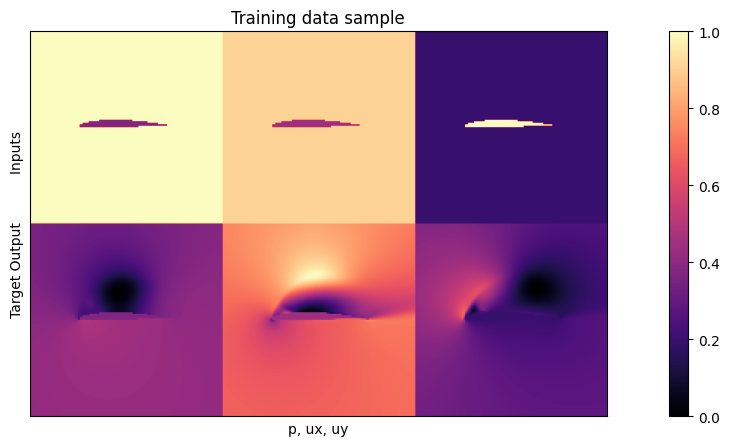

In [ ]:
import pylab
from matplotlib import cm

# helper to show three target channels: normalized, with colormap, side by side
def showSbs(a1,a2, bottom="NN Output", top="Reference", title=None):
  c=[]
  for i in range(3):
    b = np.flipud( np.concatenate((a2[...,i],a1[...,i]),axis=1).transpose())
    min, mean, max = np.min(b), np.mean(b), np.max(b);
    b -= min; b /= (max-min)
    c.append(b)
  fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
  axes.set_xticks([]); axes.set_yticks([]);
  im = axes.imshow(np.concatenate(c,axis=1), origin='upper', cmap='magma')

  pylab.colorbar(im); pylab.xlabel('p, ux, uy'); pylab.ylabel('%s           %s'%(bottom,top))
  if title is not None: pylab.title(title)

NUM=40
print("\nHere are all 3 inputs are shown at the top (mask,in x, in y) \nSide by side with the 3 output channels (p,vx,vy) at the bottom:")
showSbs( X_train[NUM],y_train[NUM], bottom="Target Output", top="Inputs", title="Training data sample")


Not surprisingly, the data still looks the same. For details, please check out the description in {doc}`supervised-airfoils`.

### Neural Network Definition
The NN Definition remains the same as in previous basic Supervised Learning Implementation

The code below implements a single convolutional block of the U-Net:

In [ ]:
import tensorflow as tf
import tensorflow_probability.python.distributions as tfd
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,UpSampling2D, BatchNormalization, ReLU, LeakyReLU, SpatialDropout2D, MaxPooling2D
from tensorflow_probability.python.layers import Convolution2DFlipout
from tensorflow.keras.models import Model

def tfBlockUnet(filters=3, transposed=False, kernel_size=4, bn=True, relu=True, pad="same", dropout=0., name=''):
    block = Sequential(name=name)
    if relu:
        block.add(ReLU())
    else:
        block.add(LeakyReLU(0.2))
    if not transposed:
        block.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=pad,
                         kernel_initializer=RandomNormal(0.0, 0.02), activation=None,strides=(2,2)))
    else:
        block.add(UpSampling2D(interpolation = 'bilinear'))
        block.add(Conv2D(filters=filters, kernel_size=(kernel_size-1), padding=pad,
                         kernel_initializer=RandomNormal(0.0, 0.02), strides=(1,1), activation=None))

    block.add(SpatialDropout2D(rate=dropout))

    if bn:
        block.add(BatchNormalization(axis=-1, epsilon=1e-05,momentum=0.9))

    return block

In [ ]:
def Bayes_DfpNet(input_shape=(128,128,3),expo=5,dropout=0.):
    channels = int(2 ** expo + 0.5)

    layer1=Sequential(name='layer1')
    layer1.add(Conv2D(filters=channels,kernel_size=4,strides=(2,2),padding='same',activation=None,data_format='channels_last'))
    layer2=tfBlockUnet(filters=channels*2,transposed=False,bn=True, relu=False,dropout=dropout,name='layer2')
    layer3=tfBlockUnet(filters=channels*2,transposed=False,bn=True, relu=False,dropout=dropout,name='layer3')
    layer4=tfBlockUnet(filters=channels*4,transposed=False,bn=True, relu=False,dropout=dropout,name='layer4')
    layer5=tfBlockUnet(filters=channels*8,transposed=False,bn=True, relu=False,dropout=dropout,name='layer5')
    layer6=tfBlockUnet(filters=channels*8,transposed=False,bn=True, relu=False,dropout=dropout,kernel_size=2,pad='valid',name='layer6')
    layer7=tfBlockUnet(filters=channels*8,transposed=False,bn=True, relu=False,dropout=dropout,kernel_size=2,pad='valid',name='layer7')

    # note, kernel size is internally reduced by one for the decoder part
    dlayer7=tfBlockUnet(filters=channels*8,transposed=True,bn=True, relu=True,dropout=dropout, kernel_size=2,pad='valid',name='dlayer7')
    dlayer6=tfBlockUnet(filters=channels*8,transposed=True,bn=True, relu=True,dropout=dropout, kernel_size=2,pad='valid',name='dlayer6')
    dlayer5=tfBlockUnet(filters=channels*4,transposed=True,bn=True, relu=True,dropout=dropout,name='dlayer5')
    dlayer4=tfBlockUnet(filters=channels*2,transposed=True,bn=True, relu=True,dropout=dropout,name='dlayer4')
    dlayer3=tfBlockUnet(filters=channels*2,transposed=True,bn=True, relu=True,dropout=dropout,name='dlayer3')
    dlayer2=tfBlockUnet(filters=channels  ,transposed=True,bn=True, relu=True,dropout=dropout,name='dlayer2')
    dlayer1=Sequential(name='outlayer')
    dlayer1.add(ReLU())
    dlayer1.add(Conv2DTranspose(3,kernel_size=4,strides=(2,2),padding='same'))

    # forward pass
    inputs=Input(input_shape)
    out1 = layer1(inputs)
    out2 = layer2(out1)
    out3 = layer3(out2)
    out4 = layer4(out3)
    out5 = layer5(out4)
    out6 = layer6(out5)
    out7 = layer7(out6)
    # ... bottleneck ...
    dout6 = dlayer7(out7)
    dout6_out6 = tf.concat([dout6,out6],axis=3)
    dout6 = dlayer6(dout6_out6)
    dout6_out5 = tf.concat([dout6, out5], axis=3)
    dout5 = dlayer5(dout6_out5)
    dout5_out4 = tf.concat([dout5, out4], axis=3)
    dout4 = dlayer4(dout5_out4)
    dout4_out3 = tf.concat([dout4, out3], axis=3)
    dout3 = dlayer3(dout4_out3)
    dout3_out2 = tf.concat([dout3, out2], axis=3)
    dout2 = dlayer2(dout3_out2)
    dout2_out1 = tf.concat([dout2, out1], axis=3)
    dout1 = dlayer1(dout2_out1)

    return Model(inputs=inputs,outputs=dout1)



Let's define the hyperparameters and create a tensorflow dataset to organize inputs and targets.

In [ ]:
import math
import matplotlib.pyplot as plt
from keras import backend as K

BATCH_SIZE=10
LR=0.001
EPOCHS = 120
KL_PREF = 5000

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train),
    seed=46168531, reshuffle_each_iteration=False).batch(BATCH_SIZE, drop_remainder=False)

def compute_lr(i, epochs, minLR, maxLR):
  if i < epochs * 0.5:
      return maxLR
  e = (i / float(epochs) - 0.5) * 2.
  # rescale second half to min/max range
  fmin = 0.
  fmax = 6.
  e = fmin + e * (fmax - fmin)
  f = math.pow(0.5, e)
  return minLR + (maxLR - minLR) * f

#Defining KL and loss function from equation 5
lgamma = tf.math.lgamma
digamma = tf.math.digamma

epochs = [1]

def KL(alpha, num_classes=10): #<----NUM_CLASSES SHOULD NOT BE 10 IN OUR RANS CASE
  #one = K.constant(np.ones((1,num_classes)),dtype=tf.float32)
  one = K.constant(np.ones_like(alpha),dtype=tf.float32) # Change here

  S = K.sum(alpha,axis=1,keepdims=True)

  kl = lgamma(S) - K.sum(lgamma(alpha),axis=1,keepdims=True) +\
      K.sum(lgamma(one),axis=1,keepdims=True) - lgamma(K.sum(one,axis=1,keepdims=True)) +\
      K.sum((alpha - one)*(digamma(alpha)-digamma(S)),axis=1,keepdims=True)

  return kl


def loss_func(y_true, output):
    # Cast y_true to float32 to match the type of output
    y_true = tf.cast(y_true, tf.float32)

    y_evidence = K.relu(output)
    alpha = y_evidence+1
    S = K.sum(alpha,axis=1,keepdims=True)
    p = alpha / S

    err = K.sum(K.pow((y_true-p),2),axis=1,keepdims=True)
    var = K.sum(alpha*(S-alpha)/(S*S*(S+1)),axis=1,keepdims=True)

    l =  K.sum(err + var,axis=1,keepdims=True)
    l = K.sum(l)


    kl =  K.minimum(1.0, epochs[0]/50) * K.sum(KL((1-y_true)*(alpha)+y_true))
    #return l + kl
    return kl

We can visualize the learning rate decay: We start off with a constant rate and after half of the `EPOCHS` we start to decay it exponentially, until arriving at half of the original learning rate.

Text(0, 0.5, 'Learning Rate')

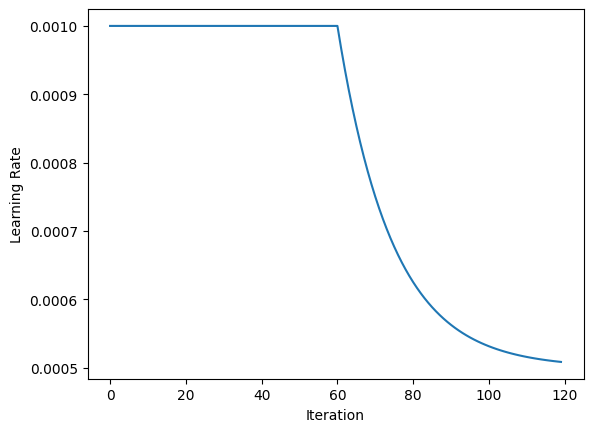

In [ ]:
lrs=[compute_lr(i, EPOCHS, 0.5*LR,LR) for i in range(EPOCHS)]
plt.plot(lrs)
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')

In [ ]:
from tensorflow.keras.optimizers import RMSprop, Adam

model=Bayes_DfpNet(expo=4)
optimizer = Adam(learning_rate=LR, beta_1=0.5,beta_2=0.9999)

num_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print('The Bayesian U-Net has {} parameters.'.format(num_params))

The Bayesian U-Net has 585667 parameters.


Should be same number of parameters as before 585667 of the conventional NN.

## Training

Now we are ready to run the training! Note that this might take a while (typically around 4 hours), as the flipout layers are significantly slower to train compared to regular layers.


In [ ]:
from tensorflow.keras.losses import mae
import math

kl_losses=[]
mae_losses=[]
total_losses=[]
mae_losses_vali=[]

for epoch in range(EPOCHS):
    # compute learning rate - decay is implemented
    currLr = compute_lr(epoch,EPOCHS,0.5*LR,LR)
    if currLr < LR:
            tf.keras.backend.set_value(optimizer.lr, currLr)

    # iterate through training data
    kl_sum = 0
    mae_sum = 0
    total_sum=0
    for i, traindata in enumerate(dataset, 0):
      # forward pass and loss computation
        with tf.GradientTape() as tape:
            inputs, targets = traindata
            prediction = model(inputs, training=True)
            loss_mae = tf.reduce_mean(mae(prediction, targets))
            #kl=sum(model.losses) #<---NEEDS CHANGE by new one
            #NEW EVIDENTIAL LOST FUNCTION. <---CHECK IS ACCUMULATING CORRECT ERRORS
            kl = loss_func(targets, prediction)
            loss_value=kl+tf.cast(loss_mae, dtype='float32')

        # backpropagate gradients and update parameters
        gradients = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # store losses per batch
        kl_sum += kl
        mae_sum += tf.reduce_mean(loss_mae)
        total_sum+=tf.reduce_mean(loss_value)

    # store losses per epoch
    kl_losses+=[kl_sum/len(dataset)]
    mae_losses+=[mae_sum/len(dataset)]
    total_losses+=[total_sum/len(dataset)]

    # validation
    outputs = model.predict(X_val)
    mae_losses_vali += [tf.reduce_mean(mae(y_val, outputs))]

    if epoch<3 or epoch%20==0:
        print('Epoch {}/{}, total loss: {:.3f}, KL loss: {:.3f}, MAE loss: {:.4f}, MAE loss vali: {:.4f}'.format(epoch, EPOCHS, total_losses[-1], kl_losses[-1], mae_losses[-1], mae_losses_vali[-1]))




3/3 [==============================] - 0s 9ms/step
Epoch 0/120, total loss: 25.154, KL loss: 24.854, MAE loss: 0.3002, MAE loss vali: 0.2203
3/3 [==============================] - 0s 8ms/step
Epoch 1/120, total loss: 0.409, KL loss: 0.123, MAE loss: 0.2860, MAE loss vali: 0.2347
3/3 [==============================] - 0s 8ms/step
Epoch 2/120, total loss: 0.313, KL loss: 0.034, MAE loss: 0.2793, MAE loss vali: 0.2618
3/3 [==============================] - 0s 8ms/step
Epoch 20/120, total loss: 0.221, KL loss: 0.004, MAE loss: 0.2172, MAE loss vali: 0.2111
3/3 [==============================] - 0s 8ms/step
Epoch 40/120, total loss: 0.205, KL loss: 0.002, MAE loss: 0.2031, MAE loss vali: 0.2003
3/3 [==============================] - 0s 8ms/step
Epoch 60/120, total loss: 0.204, KL loss: 0.002, MAE loss: 0.2023, MAE loss vali: 0.1978
3/3 [==============================] - 0s 10ms/step
Epoch 80/120, total loss: 0.195, KL loss: 0.001, MAE loss: 0.1934, MAE loss vali: 0.1912
3/3 [===============

The EVIDENTIAL NN is trained! Let's look at the loss. Since the loss consists of two separate parts, it is helpful to monitor both parts (MAE and KL).

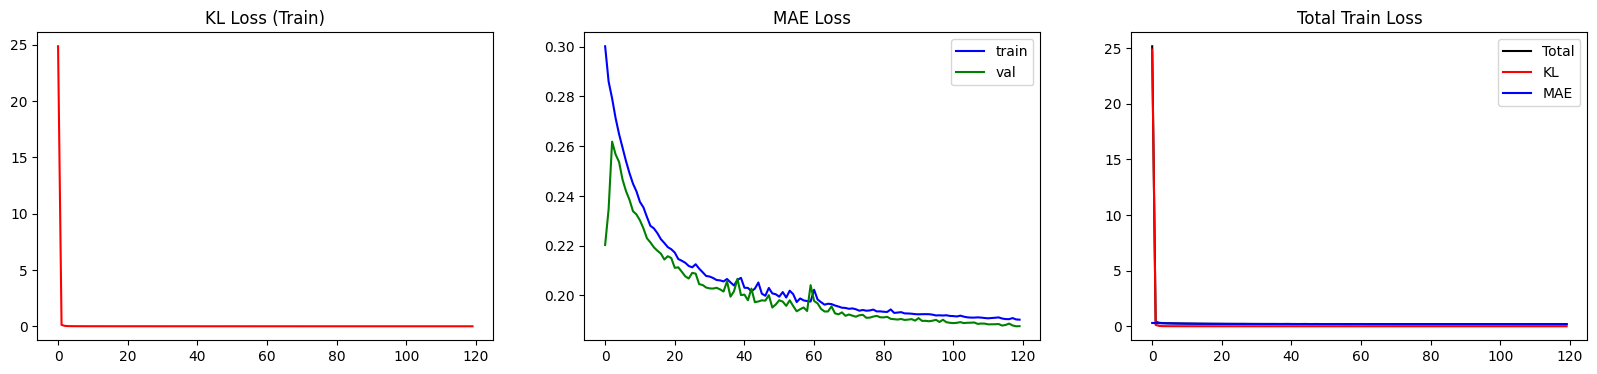

In [ ]:
fig,axs=plt.subplots(ncols=3,nrows=1,figsize=(20,4))

axs[0].plot(kl_losses,color='red')
axs[0].set_title('KL Loss (Train)')
axs[1].plot(mae_losses,color='blue',label='train')
axs[1].plot(mae_losses_vali,color='green',label='val')
axs[1].set_title('MAE Loss'); axs[1].legend()

axs[2].plot(total_losses,label='Total',color='black')
axs[2].plot(kl_losses,label='KL',color='red')
axs[2].plot(mae_losses,label='MAE',color='blue')
axs[2].set_title('Total Train Loss'); axs[2].legend()

#TODO NEED TO CHANGE THE GRAPHS SINCE THEY ARE CALCULATED ON THE FUNCTION

This way, we can double-check if minimizing one part of the loss comes at the cost of increasing the other. For our case, we observe that both parts decrease smoothly. In particular, the MAE loss is not increasing for the validation set, indicating that we are not overfitting.

It is good practice to double-check how many layers added KL-losses. We can inspect _model.losses_ for that. Since the decoder consists of 6 sequential blocks with flipout layers, we expect 6 entries in _model.losses_.

In [ ]:
# there should be 6 entries in model.losses since we have 6 blocks with flipout layers in our model
print('There are {} entries in model.losses'.format(len(model.losses)))
print(model.losses)

There are 0 entries in model.losses
[]


In [ ]:
y_pred1 = model.predict(X_train)
# Assuming your problem is a classification task, you'll need to extract the predicted class labels
y_pred_classes = np.argmax(y_pred1, axis=-1)  # Assuming the last axis represents the class probabilities

# Similarly, extract the true class labels from y_train (if it's one-hot encoded)
y_train_classes = np.argmax(y_train, axis=-1)  # Adjust the axis if necessary

# Now you can compare the predicted and true labels
X_test_wrong, y_test_wrong = X_train[np.where(y_train_classes != y_pred_classes)], y_train_classes[np.where(y_train_classes != y_pred_classes)]

# Separating Correct Responses of the CNN Classifier
X_test_correct, y_test_correct = X_train[np.where(y_train_classes == y_pred_classes)], y_train_classes[np.where(y_train_classes == y_pred_classes)]

r = 0
N = 0
E_F = np.zeros(2)

for ii in range(2):
    X_test_wrong_i, y_test_wrong_i = X_test_wrong[np.where(y_test_wrong == ii+1)], y_test_wrong[np.where(y_test_wrong == ii+1)]
    # Check if y_test_correct contains the value (ii+1) before indexing
    if (ii+1) in y_test_correct:
        # Use boolean indexing directly instead of np.where
        X_test_correct_i, y_test_correct_i = X_test_correct[np.where(y_test_correct == ii+1)], y_test_correct[np.where(y_test_correct == ii+1)]
        r = X_test_wrong_i.shape[0]
        N = X_test_wrong_i.shape[0] + X_test_correct_i.shape[0]
        E_F[ii] = (1 + r)/(1+1+N)
    else:
        print(f"Value {ii+1} not found in y_test_correct. Skipping calculation for this class.")

Reliability = 1 - 0.1*(sum(E_F))

# Calc brier score
# Check shapes of y_pred and y_test_digit before calculation
print("Shape of y_pred:", y_pred.shape)
# Assuming you have a variable named y_test_digit, make sure it's defined
# print("Shape of y_test_digit:", y_test_digit.shape)
mean_bs = np.mean((y_pred1 - y_train) ** 2)
print(f"Mean Brier score: {mean_bs}")
print(f"Reliability : {Reliability}")

10/10 [==============================] - 0s 8ms/step
Shape of y_pred: (320, 128, 3)
Mean Brier score: 0.08123347693745347
Reliability : 0.8999495208735463


Actual: [[[ 0.00465194  0.48425603 -0.01238441]
  [ 0.00464736  0.48424262 -0.01230685]
  [ 0.004646    0.48423011 -0.01224906]
  ...
  [-0.00162179  0.49624718 -0.00816833]
  [-0.00165126  0.49629456 -0.00831044]
  [-0.00168523  0.4963473  -0.00844595]]

 [[ 0.00467518  0.48419078 -0.01236602]
  [ 0.0046774   0.48417379 -0.01230454]
  [ 0.0046739   0.48416575 -0.01224591]
  ...
  [-0.00169589  0.49640451 -0.0081237 ]
  [-0.00172471  0.496451   -0.00826682]
  [-0.00175889  0.4965091  -0.00838962]]

 [[ 0.00470057  0.48413446 -0.01237248]
  [ 0.00470808  0.48410943 -0.01230539]
  [ 0.00470965  0.48408708 -0.01225553]
  ...
  [-0.00177005  0.49656185 -0.00807907]
  [-0.00180073  0.49661369 -0.00821249]
  [-0.00182805  0.49667091 -0.00833222]]

 ...

 [[ 0.00556207  0.48183974 -0.02186943]
  [ 0.0055625   0.48178521 -0.02196438]
  [ 0.00557609  0.48172979 -0.02207595]
  ...
  [-0.00369523  0.49983005 -0.02487393]
  [-0.00370975  0.4998372  -0.02470511]
  [-0.00369559  0.4998229  -0.024547

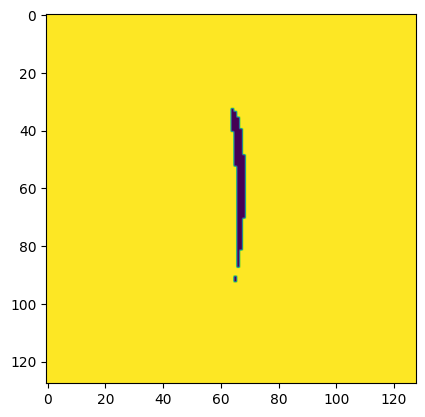

In [ ]:
probs = []
uncs = []
preds = []

def calc_prob_uncertainty(p):
    # Ensure p is a 1D array
    p = p.flatten()

    evidence = np.maximum(p, 0)

    alpha = evidence + 1

    u = 10/ alpha.sum()
    prob = alpha[np.argmax(alpha)] / alpha.sum()
    return prob, u

for pred in y_pred1:
  p, u = calc_prob_uncertainty(pred)

  probs.append(p)
  uncs.append(u)
  preds.append(np.argmax(pred))
#example
idx = 100
# Select a single channel to display (e.g., the first channel)
plt.imshow(X_train[idx][:,:,0]) # Assuming the channels are in the last dimension
print(f'Actual: {y_train[idx]}')
print(f'Predicted: {preds[idx]}') # since is a binary classifier it should say no is not a 2
print(f'Probability: {probs[idx]}')
print(f'Uncertainty: {uncs[idx]}')

some_digit = X_train[idx]
# Reshape a single channel of the image
some_digit_show = plt.imshow(X_train[idx][:,:,0]) # Select and reshape a single channel
#int(y_train_digit_cp[idx])

Now let's visualize how the EVIDENTIAL NN performs for unseen data from the validation set.

In [ ]:
REPS=10
preds=np.zeros(shape=(REPS,)+X_val.shape)
for rep in range(REPS):
    preds[rep,:,:,:,:]=model.predict(X_val)
preds_mean=np.mean(preds,axis=0)
preds_std=np.std(preds,axis=0)

3/3 [==============================] - 0s 8ms/step


Before inspecting the mean and standard deviation computed in the previous cell, let's visualize one of the outputs of the BNN. In the following plot, the input is shown in the first row, while the second row illustrates the result of a single forward pass.


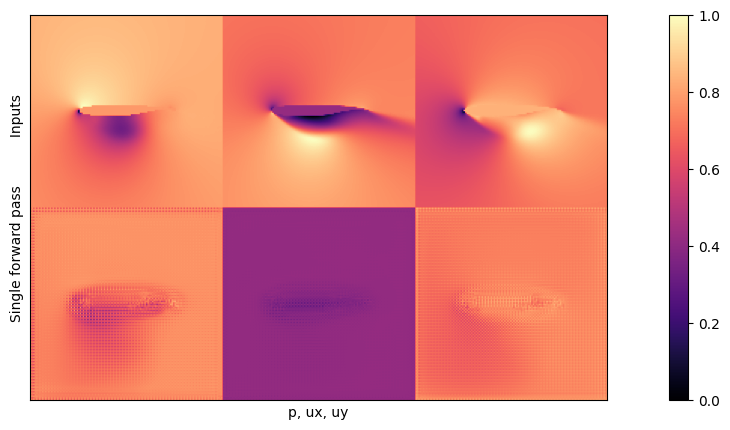

In [ ]:
NUM=16
# show a single prediction
showSbs(y_val[NUM],preds[0][NUM], top="Inputs", bottom="Single forward pass")


If you compare this image to one of the outputs from {doc}`supervised-airfoils`, you'll see that it doesn't look to different on first sight. This is a good sign, it seems the network learned to produce the content of the pressure and velocity fields.

More importantly, though, we can now visualize the uncertainty over predictions more clearly by inspecting several samples from the posterior distribution  as well as the standard deviation for a given input. Below is code for a function that visualizes precisely that (uncertainty is shown with a different colormap in order to illustrate the differences to previous non-bayesian notebook).

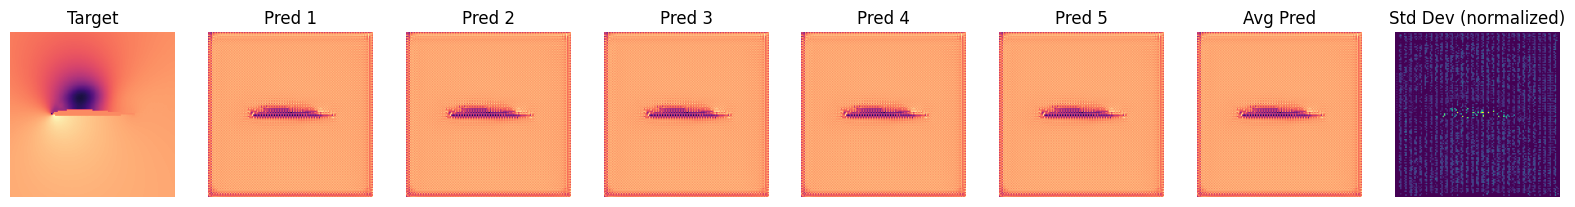

In [ ]:
# plot repeated samples from posterior for some observations
def plot_BNN_predictions(target, preds, pred_mean, pred_std, num_preds=5,channel=0):
  if num_preds>len(preds):
    print('num_preds was set to {}, but has to be smaller than the length of preds. Setting it to {}'.format(num_preds,len(preds)))
    num_preds = len(preds)

  # transpose and concatenate the frames that are to plot
  to_plot=np.concatenate((target[:,:,channel].transpose().reshape(128,128,1),preds[0:num_preds,:,:,channel].transpose(),
                          pred_mean[:,:,channel].transpose().reshape(128,128,1),pred_std[:,:,channel].transpose().reshape(128,128,1)),axis=-1)
  fig, axs = plt.subplots(nrows=1,ncols=to_plot.shape[-1],figsize=(20,4))
  for i in range(to_plot.shape[-1]):
    label='Target' if i==0 else ('Avg Pred' if i == (num_preds+1) else ('Std Dev (normalized)' if i == (num_preds+2) else 'Pred {}'.format(i)))
    colmap = cm.viridis if i==to_plot.shape[-1]-1 else cm.magma
    frame = np.flipud(to_plot[:,:,i])
    min=np.min(frame); max = np.max(frame)
    frame -= min; frame /=(max-min)
    axs[i].imshow(frame,cmap=colmap)
    axs[i].axis('off')
    axs[i].set_title(label)

OBS_IDX=5
plot_BNN_predictions(y_val[OBS_IDX,...],preds[:,OBS_IDX,:,:,:],preds_mean[OBS_IDX,...],preds_std[OBS_IDX,...])

We are looking at channel 0, i.e. the pressure here. One can observe that the dark and bright regions vary quite a bit across predictions. It is reassuring to note that - at least from visual inspection - the average (i.e. marginal) prediction is closer to the target than most of the single forward passes.

It should also be noted that each frame was normalized for the visualization. Therefore, when looking at the uncertainty frame, we can infer where the network is uncertain, but now how uncertain it is in absolute values.

In order to assess a global measure of uncertainty we can however compute an average standard deviation over all samples in the validation set.

In [ ]:
# Average Prediction with total uncertainty
uncertainty_total = np.mean(np.abs(preds_std),axis=(0,1,2))
preds_mean_global = np.mean(np.abs(preds),axis=(0,1,2,3))
print("\nAverage pixel prediction on validation set: \n pressure: {} +- {}, \n ux: {} +- {},\n uy: {} +- {}".format(np.round(preds_mean_global[0],3),np.round(uncertainty_total[0],3),np.round(preds_mean_global[1],3),np.round(uncertainty_total[1],3),np.round(preds_mean_global[2],3),np.round(uncertainty_total[2],3)))



Average pixel prediction on validation set: 
 pressure: 0.026 +- 0.0, 
 ux: 0.019 +- 0.0,
 uy: 0.05 +- 0.0


For a run with standard settings, the uncertainties are on the order of 0.01 for all three fields. As the pressure field has a smaller mean, it's uncertainty is larger in relative terms. This makes sense, as the pressure field is known to be more difficult to predict than the two velocity components.

## Test evaluation

Like in the case for a conventional neural network, let's now look at **proper** test samples, i.e. OOD samples, for which in this case we'll use new airfoil shapes. These are shapes that the network never saw in any training samples, and hence it tells us a bit about how well the network generalizes to new shapes.

As these samples are at least slightly OOD, we can draw conclusions about how well the network generalizes, which the validation data would not really tell us. In particular, we would like to investigate if the NN is more uncertain when handling OOD data. Like before, we first download the test samples ...

In [ ]:
dir = "./"
if False:
  if not os.path.isfile('data-airfoils-test.npz'):
    import urllib.request
    url="https://physicsbaseddeeplearning.org/data/data_test.npz"
    print("Downloading test data, this should be fast...")
    urllib.request.urlretrieve(url, 'data-airfoils-test.npz')
else: # cf supervised airfoil code:
    from google.colab import drive
    drive.mount('/content/gdrive')
    dir = "/content/gdrive/MyDrive/ARGONNE/VFPArgonne24/ProjectsSYCLCode/AI-Code/RANS_ENSAMBLE_MODELS&DATA/"

nptfile=np.load(dir+'data-airfoils-test.npz')
print("Loaded {}/{} test samples".format(len(nptfile["test_inputs"]),len(nptfile["test_targets"])))

Mounted at /content/gdrive
Loaded 10/10 test samples


... and then repeat the procedure from above to evaluate the BNN on the test samples, and compute the marginalized prediction and uncertainty.

In [ ]:
X_test = np.moveaxis(nptfile["test_inputs"],1,-1)
y_test = np.moveaxis(nptfile["test_targets"],1,-1)

REPS=10
preds_test=np.zeros(shape=(REPS,)+X_test.shape)
for rep in range(REPS):
    preds_test[rep,:,:,:,:]=model.predict(X_test)
preds_test_mean=np.mean(preds_test,axis=0)
preds_test_std=np.std(preds_test,axis=0)
test_loss = tf.reduce_mean(mae(preds_test_mean, y_test))

print("\nAverage test error: {}".format(test_loss))


1/1 [==============================] - 0s 22ms/step

Average test error: 0.19842438646330032


In [ ]:
# Average Prediction with total uncertainty
uncertainty_test_total = np.mean(np.abs(preds_test_std),axis=(0,1,2))
preds_test_mean_global = np.mean(np.abs(preds_test),axis=(0,1,2,3))
print("\nAverage pixel prediction on test set: \n pressure: {} +- {}, \n ux: {} +- {},\n uy: {} +- {}".format(np.round(preds_test_mean_global[0],3),np.round(uncertainty_test_total[0],3),np.round(preds_test_mean_global[1],3),np.round(uncertainty_test_total[1],3),np.round(preds_test_mean_global[2],3),np.round(uncertainty_test_total[2],3)))



Average pixel prediction on test set: 
 pressure: 0.031 +- 0.0, 
 ux: 0.023 +- 0.0,
 uy: 0.061 +- 0.0


This is reassuring: The uncertainties on the OOD test set with new shapes are at least slightly higher than on the validation set.

### Visualizations

The following graph visualizes these measurements: it shows the mean absolute errors for validation and test sets side by side, together with the uncertainties of the predictions as error bars:

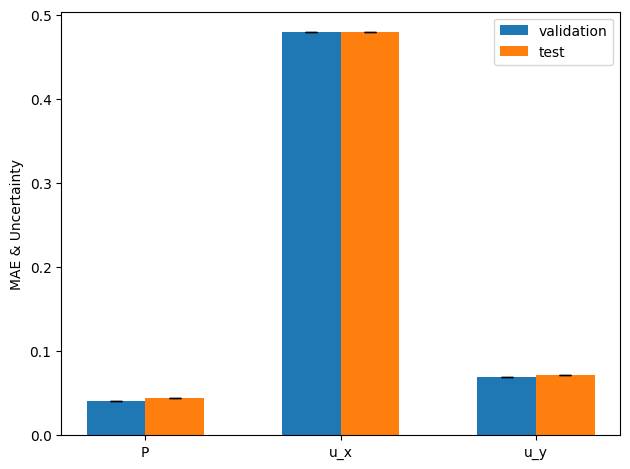

In [ ]:
# plot per channel MAE with uncertainty
val_loss_c, test_loss_c = [], []
for channel in range(3):
  val_loss_c.append( tf.reduce_mean(mae(preds_mean[...,channel], y_val[...,channel])) )
  test_loss_c.append( tf.reduce_mean(mae(preds_test_mean[...,channel], y_test[...,channel])) )

fig, ax = plt.subplots()
ind = np.arange(len(val_loss_c)); width=0.3
bars1 = ax.bar(ind - width/2, val_loss_c, width, yerr=uncertainty_total, capsize=4, label="validation")
bars2 = ax.bar(ind + width/2, test_loss_c, width, yerr=uncertainty_test_total, capsize=4, label="test")
ax.set_ylabel("MAE & Uncertainty")
ax.set_xticks(ind); ax.set_xticklabels(('P', 'u_x', 'u_y'))
ax.legend(); plt.tight_layout()

The mean error is clearly larger, and the slightly larger uncertainties of the predictions are likewise visible via the error bars.

In general it is hard to obtain a calibrated uncertainty estimate, but since we are dealing with a fairly simple problem here, the BNN is able to estimate the uncertainty reasonably well.

The next graph shows the differences of the BNN predictions for a single case of the test set (using the same style as for the validation sample above):

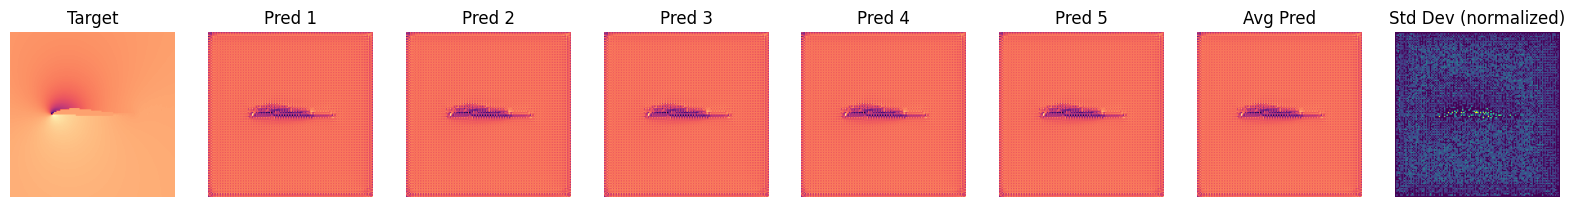

In [ ]:
OBS_IDX=5
plot_BNN_predictions(y_test[OBS_IDX,...],preds_test[:,OBS_IDX,:,:,:],preds_test_mean[OBS_IDX,...],preds_test_std[OBS_IDX,...])

We can also visualize several shapes from the test set together with the corresponding marginalized prediction and uncertainty.

Text(0.5, 1.0, 'Std. Dev')

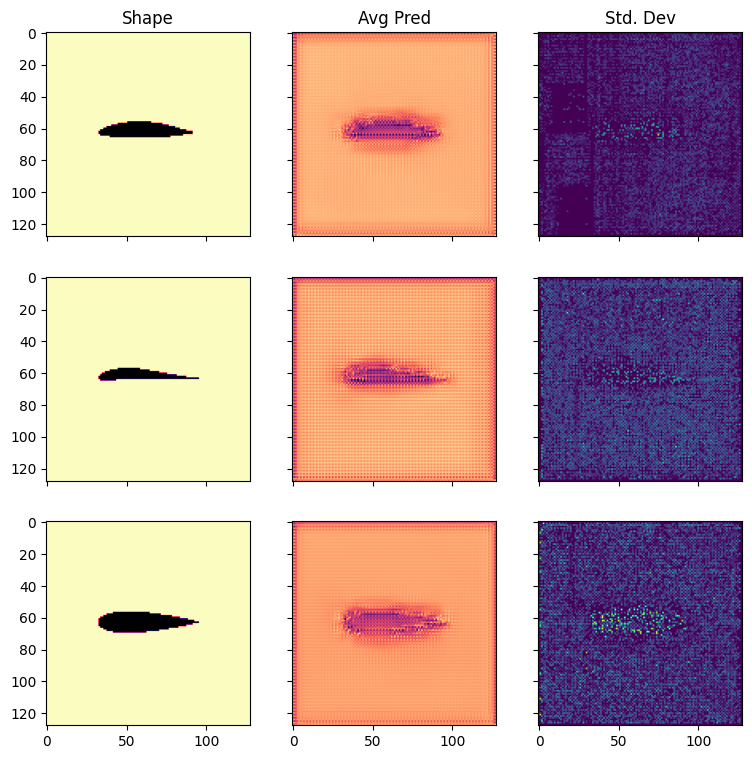

In [ ]:
IDXS = [1,3,8]
CHANNEL = 0
fig, axs = plt.subplots(nrows=len(IDXS),ncols=3,sharex=True, sharey = True, figsize = (9,len(IDXS)*3))
for i, idx in enumerate(IDXS):
  axs[i][0].imshow(np.flipud(X_test[idx,:,:,CHANNEL].transpose()), cmap=cm.magma)
  axs[i][1].imshow(np.flipud(preds_test_mean[idx,:,:,CHANNEL].transpose()), cmap=cm.magma)
  axs[i][2].imshow(np.flipud(preds_test_std[idx,:,:,CHANNEL].transpose()), cmap=cm.viridis)
axs[0][0].set_title('Shape')
axs[0][1].set_title('Avg Pred')
axs[0][2].set_title('Std. Dev')


As we can see, the shapes from the test set differ quite a bit from another. Nevertheless, the uncertainty estimate is reasonably distributed. It is especially high in the boundary layer around the airfoil, and in the regions of the low pressure pocket.

### Discussion

Despite these promising results, there are still several issues with Bayesian Neural Nets, limiting their use in many practical applications. One serious drawback is the need for additional scaling of the KL-loss and the fact that there is no convincing argument on why it is necessary yet (read e.g. [here](http://proceedings.mlr.press/v119/wenzel20a/wenzel20a.pdf) or [here](https://arxiv.org/abs/2008.05912)).
Furthermore, some people think that assuming independent normal distributions as variational approximations to the posterior is an oversimplification since in practice the weights are actually highly correlated ([paper](https://arxiv.org/abs/1909.00719)). Other people instead argue that this might not be an issue, as long as the networks in use are deep enough ([paper](https://arxiv.org/abs/2002.03704)). On top of that, there is research on different (e.g. heavy-tailed) priors other than normals and many other aspects of BNNs.

## Next steps

But now it's time to experiment with BNNs yourself.

* One interesting thing to look at is how the behavior of our BNN changes, if we adjust the KL-prefactor. In the training loop above we set it to 5000 without further justification. You can check out what happens, if you use a value of 1, as it is suggested by the theory, instead of 5000. According to our implementation, this should make the network 'more bayesian', since we assign larger importance to the KL-divergence than before.

* So far, we have only worked with variational BNNs, implemented via TensorFlows probabilistic layers. Recall that there is a simpler way of getting uncertainty estimates: Using dropout not only at training, but also at inference time. You can check out how the outputs change for that case. In order to do so, you can, for instance, just pass a non-zero dropout rate to the network specification and change the prediction phase in the above implementation from _model.predict(...)_ to _model(..., training=True)_. Setting the _training=True_ flag will tell TensorFlow to forward the input as if it were training data and hence, it will apply dropout. Please note that the _training=True_ flag can also affect other features of the network. Batch normalization, for instance, works differently in training and prediction mode. As long as we don't deal with overly different data and use sufficiently large batch-sizes, this should not introduce large errors, though. Sensible dropout rates to start experimenting with are e.g. around 0.1.